# Reading Data

## Using standard data structures

In [284]:
driver = 1
trip = 2

In [285]:
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [286]:
def read_trip_data(driver, trip, folder_path, header = True):
    full_path = "{0}/{1}/{2}.csv".format(folder_path, driver, trip)
    with open(full_path, 'r') as file:
            contents = file.read()
       
    lines = contents.split('\n')
    split_lines = []
    for line in lines:
        split_lines.append(line.split(','))
    
    while split_lines[-1] == ['']:
        split_lines.pop(len(split_lines) - 1)
    
    if header:
        split_lines.pop(0)
    
    data = []
    for line in split_lines:
        data.append([float(i) for i in line])
        
    return data

In [287]:
data_folder = '/Volumes/DATA/Data/Kaggle/AxaDriverTelematics/drivers/'

In [288]:
data = read_trip_data(driver, trip, data_folder)

In [289]:
data[0]

[0.0, 0.0]

In [290]:
col_x = []
col_y = []
for row in data:
    col_x.append(row[0])
    col_y.append(row[1])

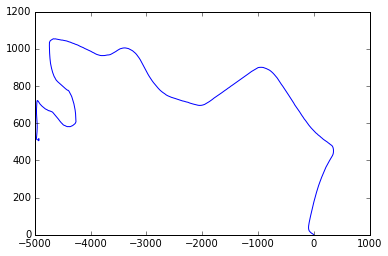

In [291]:
plt.plot(col_x, col_y)

In [292]:
data_changes = []
for i in range(1, len(data)):
    row = data[i]
    prev_row = data[i-1]
    changes = []
    
    for j in range(len(row)):
        changes.append(row[j] - prev_row[j])
        
    data_changes.append(changes)

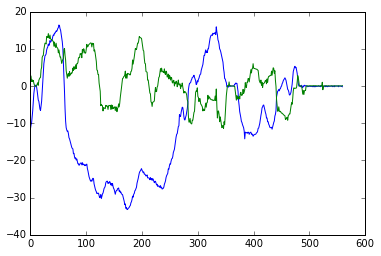

In [293]:
plt.plot(data_changes)

In [294]:
speed = []
for row in data_changes:
    squared_sum = 0
    for item in row:
        squared_sum += item ** 2
       
    speed.append(math.sqrt(squared_sum))

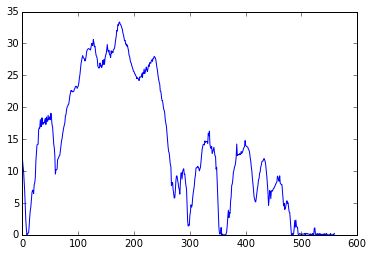

In [295]:
plt.plot(speed)

In [296]:
acceleration = []
for i in range(1, len(speed)):
    acceleration.append(speed[i] - speed[i-1])

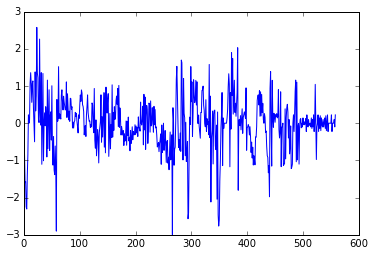

In [297]:
plt.plot(acceleration)

In [298]:
mean = sum(acceleration) / len(acceleration)
mean

-0.0208164759671639

In [299]:
sd = math.sqrt(sum([pow(i - mean, 2) for i in acceleration]) / len(acceleration))
sd

0.7272852393819756

## Using Pandas

###Module import:

In [300]:
import numpy as np
import pandas as pd
import math

####Inline graphcis:

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

###Trip data import

In [301]:
path = '/Volumes/DATA/Data/Kaggle/AxaDriverTelematics/drivers/{0}/{1}.csv'.format(driver, trip)
data_raw = pd.read_csv(path)

In [302]:
data_raw.head()

,x,y
0,0.0,0.0
1,-11.5,2.9
2,-22.0,5.5
3,-31.9,6.7
4,-40.1,8.4


In [303]:
data_raw.describe()

,x,y
count,561.000000,561.000000
mean,-3222.470053,665.228164
std,1938.794252,249.106723
min,-4970.100000,0.000000
25%,-4760.900000,507.100000
50%,-4286.700000,667.100000
75%,-1383.900000,848.700000
max,352.300000,1053.900000


###Feature extraction

In [304]:
data = data_raw.copy()
data['change_x'] = data_raw.x - data_raw.x.shift(1)
data['change_y'] = data_raw.y - data_raw.y.shift(1)

Speed and acceleration

In [305]:
data['speed'] = np.sqrt(pow(data.change_x, 2) +  pow(data.change_y, 2))
data['acceleration'] = data.speed - data.speed.shift(1)

Functions for computing the angle between two vectors, i.e. change of direction of the car from one reading to the next.

In [308]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

In [309]:
def radiants_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    angle = np.arccos(np.clip(np.dot(v1_u, v2_u),-1,1))

    return angle

In [310]:
data['direction_change'] = np.nan

In [311]:
index_change_x = data.columns.get_loc('change_x')
index_change_y = data.columns.get_loc('change_y')
index_direction_change = data.columns.get_loc('direction_change')

for i in range(1, data.shape[0]):
    current_vector = [data.iloc[i, index_change_x], data.iloc[i, index_change_y]]
    previous_vector = [data.iloc[i-1, index_change_x], data.iloc[i-1, index_change_y]]
    data.iloc[i, index_direction_change] = radiants_between(current_vector, previous_vector)

In [322]:
data['speed_X_acceleration'] = data.speed * data.acceleration
data['speed_X_direction_change'] = data.speed * data.direction_change
data['acceleration_X_direction_change'] = data.acceleration * data.direction_change
data['speed_X_acceleration_X_direction_change'] = data.speed * data.acceleration * data.direction_change

Removing data points with very low speed (standing still). Strong directional changes with very little actual movements could be due to GPS readings varying slightly without the car moving at all. Cutoff value??? 

In [307]:
data = data[data.speed > .25]

### Summary and Plots

In [323]:
data.head()

,x,y,change_x,change_y,speed,acceleration,direction_change,speed_X_acceleration,speed_X_direction_change,acceleration_X_direction_change,speed_X_acceleration_X_direction_change
1,-11.5,2.9,-11.5,2.9,11.860017,NaN,NaN,NaN,NaN,NaN,NaN
2,-22.0,5.5,-10.5,2.6,10.817116,-1.042901,0.004287,-11.281179,0.046374,-0.004471,-0.048364
3,-31.9,6.7,-9.9,1.2,9.972462,-0.844654,0.122113,-8.423280,1.217766,-0.103143,-1.028591
4,-40.1,8.4,-8.2,1.7,8.374366,-1.598096,0.083798,-13.383044,0.701751,-0.133917,-1.121466
5,-46.8,9.6,-6.7,1.2,6.806614,-1.567751,0.027196,-10.671078,0.185111,-0.042636,-0.290209


In [324]:
data.describe()

,x,y,change_x,change_y,speed,acceleration,direction_change,speed_X_acceleration,speed_X_direction_change,acceleration_X_direction_change,speed_X_acceleration_X_direction_change
count,477.000000,477.000000,477.000000,477.000000,477.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000
mean,-2977.942767,694.532914,-10.333753,1.060168,16.146490,-0.012522,0.104606,0.162518,0.796479,0.016757,0.058589
std,1956.752620,254.689023,14.155827,6.067461,9.169612,0.778816,0.280895,10.454250,0.828402,0.248002,1.059272
min,-4970.100000,2.900000,-33.200000,-11.400000,0.316228,-2.998363,0.000000,-29.956518,0.000000,-1.735737,-8.023913
25%,-4674.300000,582.000000,-24.700000,-3.800000,8.374366,-0.399714,0.010176,-6.199401,0.164678,-0.013803,-0.201331
50%,-4157.400000,707.800000,-10.700000,1.000000,14.045640,0.025149,0.040260,0.184096,0.678380,0.000155,0.002057
75%,-908.700000,888.600000,0.800000,4.600000,25.583784,0.444403,0.086041,5.083768,1.126742,0.017284,0.208296
max,352.300000,1053.900000,16.400000,14.100000,33.373642,2.575149,3.052543,37.221327,5.776428,2.975629,9.803658


Trip

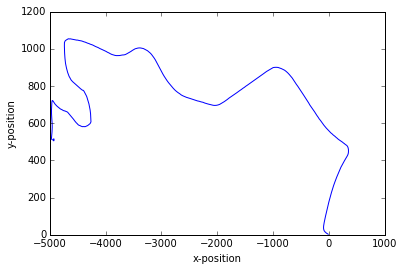

In [327]:
plt.plot(data.x, data.y)
plt.xlabel('x-position')
plt.ylabel('y-position')

Speed

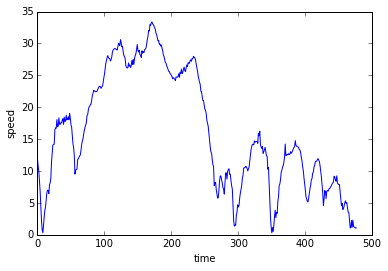

In [329]:
plt.plot(data.speed)
plt.xlabel('time')
plt.ylabel('speed')

Acceleration

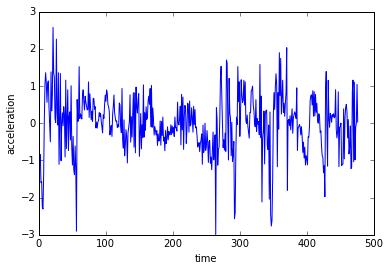

In [330]:
plt.plot(data.acceleration)
plt.xlabel('time')
plt.ylabel('acceleration')

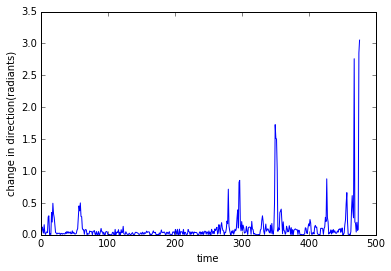

In [331]:
plt.plot(data.direction_change)
plt.xlabel('time')
plt.ylabel('change in direction(radiants)')

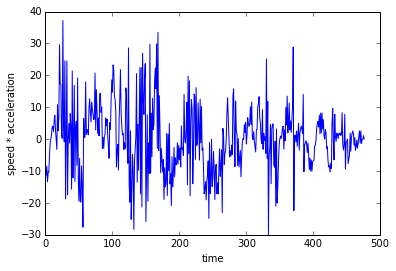

In [332]:
plt.plot(data.speed_X_acceleration)
plt.xlabel('time')
plt.ylabel('speed * acceleration')

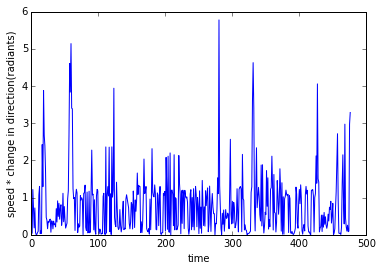

In [333]:
plt.plot(data.speed_X_direction_change)
plt.xlabel('time')
plt.ylabel('speed * change in direction(radiants)')

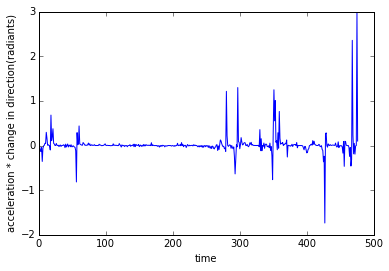

In [334]:
plt.plot(data.acceleration_X_direction_change)
plt.xlabel('time')
plt.ylabel('acceleration * change in direction(radiants)')

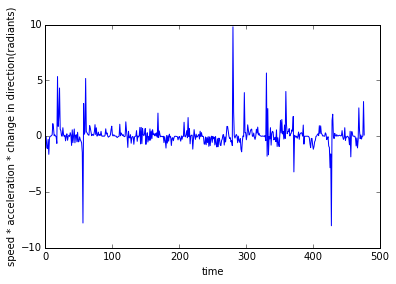

In [335]:
plt.plot(data.speed_X_acceleration_X_direction_change)
plt.xlabel('time')
plt.ylabel('speed * acceleration * change in direction(radiants)')

### Summarizing trip

In [409]:
means = data.loc[:, 'speed': ].mean()
std  = data.loc[:, 'speed': ].std()

Extend column names

In [410]:
new_index_mean = []
for name in means.index:
    new_index_mean.append('mean_{0}'.format(name))

In [411]:
means.index = new_index_mean

In [412]:
new_index_std = []
for name in std.index:
    new_index_std.append('std_{0}'.format(name))

In [413]:
std.index = new_index_std

Create complete summary

In [449]:
summary_row = [driver]
summary_row.extend(means.values)
summary_row.extend(std.values)

Create blank dataframe

In [450]:
summary_columns = ['driver']
summary_columns.extend(means.index.tolist())
summary_columns.extend(std.index.tolist())
summary = pd.DataFrame(columns = summary_columns)

Add trip stats

In [451]:
summary.loc[trip] = summary_row

In [452]:
summary

,driver,mean_speed,mean_acceleration,mean_direction_change,mean_speed_X_acceleration,mean_speed_X_direction_change,mean_acceleration_X_direction_change,mean_speed_X_acceleration_X_direction_change,std_speed,std_acceleration,std_direction_change,std_speed_X_acceleration,std_speed_X_direction_change,std_acceleration_X_direction_change,std_speed_X_acceleration_X_direction_change
2,1,16.14649,-0.012522,0.104606,0.162518,0.796479,0.016757,0.058589,9.169612,0.778816,0.280895,10.45425,0.828402,0.248002,1.059272


In [453]:
import os

In [454]:
os.listdir()

['.git',
 '.idea',
 '.ipynb_checkpoints',
 'data_exploration_notebook.ipynb',
 'MoinFarhad',
 'pandas_tutorial.ipynb',
 'README.md',
 'src']